<a href="https://colab.research.google.com/github/Remonah-3/Github_Assignment/blob/master/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shapes -> X_train: (48000, 784) X_val: (12000, 784) X_test: (10000, 784)


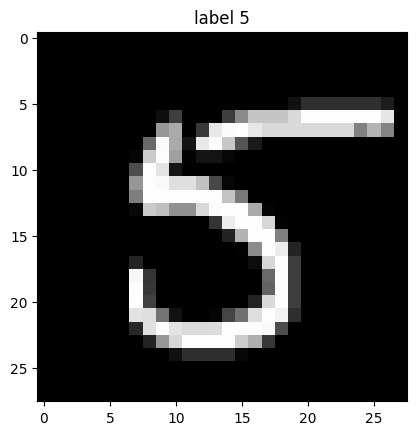

In [1]:
# Load & preprocess
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# load
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# flatten (28x28 -> 784) and normalize to [0,1]
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float32) / 255.0

# one-hot
def to_one_hot(y, n_classes=10):
    return np.eye(n_classes)[y]

y_train_oh = to_one_hot(y_train, 10)
y_test_oh  = to_one_hot(y_test, 10)

# split training
X_train, X_val, y_train_oh, y_val_oh, y_train, y_val = train_test_split(
    X_train, y_train_oh, y_train, test_size=0.2, random_state=42
)

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

plt.imshow(X_train[0].reshape(28,28), cmap='gray'); plt.title(f'label {y_train[0]}'); plt.show()


In [2]:
# Mini-batch iterator
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.n = X.shape[0]
        self.seed = seed

    def __iter__(self):
        rng = np.random.RandomState(self.seed)
        idx = np.arange(self.n)
        rng.shuffle(idx)
        for start in range(0, self.n, self.batch_size):
            batch_idx = idx[start:start+self.batch_size]
            yield self.X[batch_idx], self.y[batch_idx]


In [3]:
class ScratchSimpleNeuralNetworkClassifier:
    def __init__(self,
                 n_features=784,
                 n_nodes1=400,
                 n_nodes2=200,
                 n_output=10,
                 lr=0.01,
                 n_epochs=10,
                 batch_size=20,
                 seed=0):
        np.random.seed(seed)
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size

        sigma = 0.01
        # weight shapes
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)
        self.b1 = np.zeros((1, n_nodes1))
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.b2 = np.zeros((1, n_nodes2))
        self.W3 = sigma * np.random.randn(n_nodes2, n_output)
        self.b3 = np.zeros((1, n_output))

    # activations
    def tanh(self, x): return np.tanh(x)
    def tanh_grad_from_a(self, a): return 1.0 - a**2
    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

    # forward
    def forward(self, X):
        self.X = X  # save for backprop
        self.A1 = X.dot(self.W1) + self.b1
        self.Z1 = self.tanh(self.A1)
        self.A2 = self.Z1.dot(self.W2) + self.b2
        self.Z2 = self.tanh(self.A2)
        self.A3 = self.Z2.dot(self.W3) + self.b3
        self.Z3 = self.softmax(self.A3)
        return self.Z3


In [4]:
class ScratchSimpleNeuralNetworkClassifier(ScratchSimpleNeuralNetworkClassifier):
    def loss(self, y_true, y_pred):
        eps = 1e-7
        return -np.sum(y_true * np.log(y_pred + eps)) / y_true.shape[0]

    def backward(self, y_true):
        m = y_true.shape[0]  # batch size

        # output layer gradient
        dA3 = (self.Z3 - y_true) / m
        dW3 = self.Z2.T.dot(dA3)
        db3 = np.sum(dA3, axis=0, keepdims=True)

        # second hidden layer gradients
        dZ2 = dA3.dot(self.W3.T)
        dA2 = dZ2 * self.tanh_grad_from_a(self.Z2)
        dW2 = self.Z1.T.dot(dA2)
        db2 = np.sum(dA2, axis=0, keepdims=True)

        # first hidden layer gradients
        dZ1 = dA2.dot(self.W2.T)
        dA1 = dZ1 * self.tanh_grad_from_a(self.Z1)
        dW1 = self.X.T.dot(dA1)
        db1 = np.sum(dA1, axis=0, keepdims=True)

        # store gradients
        self.dW1, self.db1 = dW1, db1
        self.dW2, self.db2 = dW2, db2
        self.dW3, self.db3 = dW3, db3

    def update_params(self):
        self.W1 -= self.lr * self.dW1
        self.b1 -= self.lr * self.db1
        self.W2 -= self.lr * self.dW2
        self.b2 -= self.lr * self.db2
        self.W3 -= self.lr * self.dW3
        self.b3 -= self.lr * self.db3


Epoch 1/10 - Train Loss: 0.5001, Val Loss: 0.2610
Epoch 2/10 - Train Loss: 0.2115, Val Loss: 0.1718
Epoch 3/10 - Train Loss: 0.1477, Val Loss: 0.1278
Epoch 4/10 - Train Loss: 0.1087, Val Loss: 0.1092
Epoch 5/10 - Train Loss: 0.0862, Val Loss: 0.1452
Epoch 6/10 - Train Loss: 0.0698, Val Loss: 0.0985
Epoch 7/10 - Train Loss: 0.0556, Val Loss: 0.0880
Epoch 8/10 - Train Loss: 0.0462, Val Loss: 0.0942
Epoch 9/10 - Train Loss: 0.0359, Val Loss: 0.0877
Epoch 10/10 - Train Loss: 0.0290, Val Loss: 0.0807


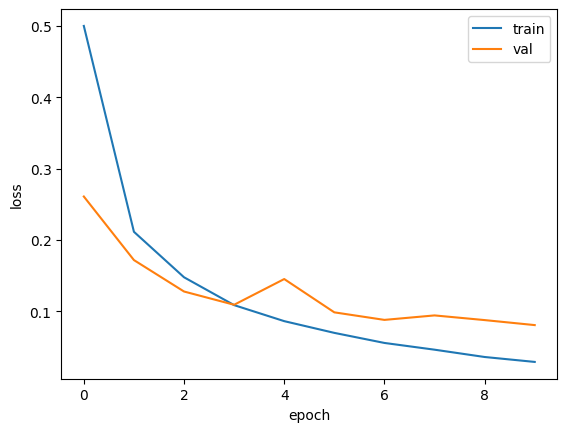

Train acc: 0.993
Val acc:   0.9775833333333334
Test acc:  0.975


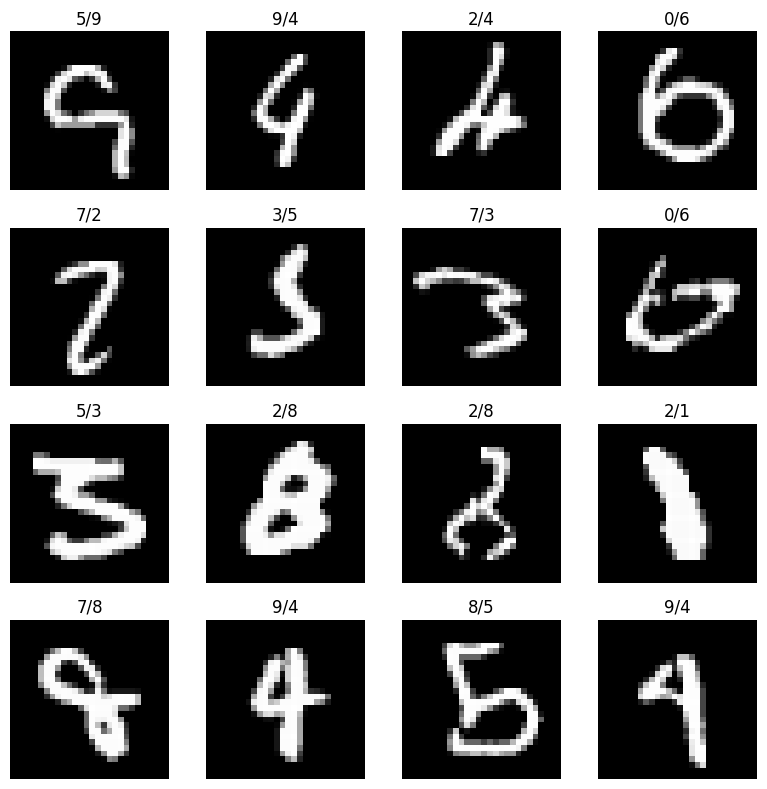

In [5]:
class ScratchSimpleNeuralNetworkClassifier(ScratchSimpleNeuralNetworkClassifier):
    def fit(self, X, y_oh, X_val=None, y_val_oh=None):
        self.train_loss = []
        self.val_loss = []

        for epoch in range(self.n_epochs):
            epoch_losses = []
            # use mini-batches of size 20
            for X_batch, y_batch in GetMiniBatch(X, y_oh, batch_size=self.batch_size, seed=epoch):
                y_pred = self.forward(X_batch)
                loss = self.loss(y_batch, y_pred)
                epoch_losses.append(loss)

                # backward + update
                self.backward(y_batch)
                self.update_params()

            avg_train_loss = np.mean(epoch_losses)
            self.train_loss.append(avg_train_loss)

            if X_val is not None and y_val_oh is not None:
                val_pred = self.forward(X_val)
                val_loss = self.loss(y_val_oh, val_pred)
                self.val_loss.append(val_loss)
                print(f"Epoch {epoch+1}/{self.n_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{self.n_epochs} - Train Loss: {avg_train_loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def score(self, X, y_labels):
        preds = self.predict(X)
        return np.mean(preds == y_labels)

    def plot_learning_curve(self):
        plt.plot(self.train_loss, label='train')
        if len(self.val_loss): plt.plot(self.val_loss, label='val')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.show()

    def show_misclassified(self, X, y_true_labels, num=36):
        preds = self.predict(X)
        wrong = np.where(preds != y_true_labels)[0]
        num = min(num, len(wrong))
        plt.figure(figsize=(8,8))
        for i in range(num):
            idx = wrong[i]
            plt.subplot(int(np.sqrt(num)), int(np.sqrt(num)), i+1)
            plt.imshow(X[idx].reshape(28,28), cmap='gray')
            plt.title(f"{preds[idx]}/{y_true_labels[idx]}")
            plt.axis('off')
        plt.tight_layout(); plt.show()


model = ScratchSimpleNeuralNetworkClassifier(
    n_features=784, n_nodes1=400, n_nodes2=200, n_output=10,
    lr=0.1, n_epochs=10, batch_size=20, seed=0
)

# fit
model.fit(X_train, y_train_oh, X_val, y_val_oh)

# plots & scores
model.plot_learning_curve()
print("Train acc:", model.score(X_train, y_train))
print("Val acc:  ", model.score(X_val, y_val))
print("Test acc: ", model.score(X_test, y_test))

model.show_misclassified(X_test, y_test, num=16)
